## 项目: 机票航班延误预测

## 开始

我们知道，航班延误对于旅客、售卖机票的平台以及航空公司都是一个比较头疼的问题。造成航班延误的因素有很多，包括台风、雾霾、飞机故障、航空管制等等原因。在这个项目中，我们将探索在飞机起飞前2小时做航班延误预测这个实际问题，你将从实际问题出发，探索数据，抽取数据特征，构建模型并作出预测。

这个项目的数据来自[航班动态起降数据集](https://www.kesci.com/home/dataset/59793a5a0d84640e9b2fedd3)（数据集由和鲸社区提供），该数据集用2015年5月到2017年5月的机场情况作为训练集，用201年6月作为测试集。你可以通过报名该比赛获取数据集，另外，为了方便大家获取数据，我们也提供了一个[下载地址](https://static-documents.s3.cn-north-1.amazonaws.com.cn/nd101/MLND+documents/data.zip)，请下载后放置data文件夹中。

**数据说明：**


- ./data/2015年5月到2017年5月城市天气.csv
- ./data/2015年5月到2017年5月航班动态数据.csv
- ./data/2015年5月到2017年5月特情.xlsx
- ./data/机场城市对应表.xlsx


In [1]:
# 为这个项目导入需要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print('你已经成功载入所需要的库！')

你已经成功载入所需要的库！


## 数据初探

### 导入数据
我们先导入数据，然后观察头部数据。可以使用[read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html), [read_excel](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html) 分别加载对应格式的数据，然后使用[head](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.head.html)观察前5条数据。

In [7]:
# 文件路径 './data/2015年5月到2017年5月航班动态数据.csv'
# 注意使用字符编码 encoding="gb2312"
# TODO: 根据以上提示信息，导入航班数据
flight_data_original = pd.read_csv('./data/2015年5月到2017年5月航班动态数据.csv', encoding ="gb2312")

# 文件路径 "./data/2015年5月到2017年5月城市天气.csv"
# TODO：根据以上提示信息，导入天气数据
weather_original = pd.read_csv('./data/2015年5月到2017年5月城市天气.csv')

# 文件路径 "./data/机场城市对应表.xlsx"
# TODO：根据以上提示信息，导入城市与机场对应数据
airport_city_original = pd.read_excel("./data/机场城市对应表.xlsx")

# 文件路径 "./data/2015年5月到2017年5月特情.xlsx"
# TODO：根据以上提示信息，导入特情数据
special_original =pd.read_excel("./data/2015年5月到2017年5月特情.xlsx")

### 观察数据
使用 [head](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.head.html)观察前5条数据。

In [8]:
#将数据做一次备份
flight_data = flight_data_original.copy()
weather = weather_original.copy()
airport_city = airport_city_original.copy()
special = special_original.copy()

# 观察航班数据
flight_data.head(20)

# 观察天气数据
weather.head()

# 通过观察，发现有一列没有用的空表格 “Unnamed: 5”，你需要使用 `del` 将其从 `weather` 数据中删除
if 'Unnamed: 5' in weather:
    del weather["Unnamed: 5"]
weather.head()

# 观察城市与机场对应数据
airport_city.head()

# 观察特情数据
special.head()



,特情机场,收集时间,开始时间,结束时间,特情内容
0,csx,2015-04-30 19:52:45Z,2015-05-01 12:00:00Z,2015-05-01 16:00:00Z,长沙机场航班延误黄色预警提示：预计明日（5月1日）12:00-16:00长沙黄花机场受雷雨天...
1,wuh,2015-05-01 08:13:39Z,2015-05-01 08:00:00Z,2015-05-01 12:00:00Z,目前，8时-12时雷雨，期间进出港航班可能受到影响。
2,khn,2015-05-01 08:14:18Z,2015-05-01 14:00:00Z,2015-05-01 17:00:00Z,预计，14时-17时小雷雨，期间进出港航班可能受到影响。
3,swa,2015-05-01 08:24:28Z,2015-05-01 13:00:00Z,2015-05-01 17:00:00Z,预计，13时-17时雷雨，期间进出港航班可能受到影响。
4,zha,2015-05-01 08:24:56Z,2015-05-01 13:00:00Z,2015-05-01 17:00:00Z,预计，13时-17时雷雨，期间进出港航班可能受到影响。


#### 问题1：我们知道，一个有监督学习问题是总有一个需要预测的目标值，那么在这个问题中，你通过了解此问题的背景以及观察以上的数据，认为此任务中的目标值是什么？在已有的数据中，给出了预测目标值吗？如果没有的话，我们要如何获得这个目标值呢？

回答问题：
- 目标值：根据历史的天气、特情等信息，判断未来某一航班是否延误
- 已有的数据中没有给出目标值，需要根据已有数据集计算航班在特定天气下的延误情况

### 整理targets值

根据以上对数据的初步观察，我们发现，这样的实际问题的数据是非常不规整的。数据的targets标签并没有显式地给出，而是需要自己整理。在这一小节，我们根据飞行数据 `flight_data` 整理出我们需要的targets。

我们首先定义延误时间：实际起飞时间与计划起飞时间的差；然后，我们以延误时长是否超过3小时来定义targets。同时观察到“航班是否取消”这一列数据，针对数据中的“取消”的航班，我们直接可以将其延误时间设置成12小时。

**建议**：用[numpy.where](https://numpy.org/devdocs/reference/generated/numpy.where.html?highlight=where#numpy.where)按条件选择延误时间是否超过三小时，如果超过三小时则延误目标值取1，否则延误目标值取0；另外也用[numpy.where](https://numpy.org/devdocs/reference/generated/numpy.where.html?highlight=where#numpy.where)按条件选择`flight_data['航班是否取消']`是否为 `取消`,如果是取消则直接可以将其延误时间设置成12小时。

In [9]:
#检查 flight_data 的时间列类型是否符合预期
flight_data.info()

#不符合预期将时间相关的 column 类型设置为 datetime
flight_data['计划起飞时间'] = pd.to_datetime(flight_data['计划起飞时间'], unit='s')
flight_data['计划到达时间'] = pd.to_datetime(flight_data['计划到达时间'], unit='s')
flight_data['实际起飞时间'] = pd.to_datetime(flight_data['实际起飞时间'], unit='s')
flight_data['实际到达时间'] = pd.to_datetime(flight_data['计划到达时间'], unit='s')

#再次检查类型
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7518638 entries, 0 to 7518637
Data columns (total 9 columns):
出发机场      object
到达机场      object
航班编号      object
计划起飞时间    int64
计划到达时间    int64
实际起飞时间    float64
实际到达时间    float64
飞机编号      float64
航班是否取消    object
dtypes: float64(3), int64(2), object(4)
memory usage: 516.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7518638 entries, 0 to 7518637
Data columns (total 9 columns):
出发机场      object
到达机场      object
航班编号      object
计划起飞时间    datetime64[ns]
计划到达时间    datetime64[ns]
实际起飞时间    datetime64[ns]
实际到达时间    datetime64[ns]
飞机编号      float64
航班是否取消    object
dtypes: datetime64[ns](4), float64(1), object(4)
memory usage: 516.3+ MB


In [10]:
##由于数据集较大，运算速度慢，先取 sample 进行逻辑的处理和运算，验证后再改动原有数据
#取 sample
flight_data_sample = flight_data.sample(200)

#计算起飞延误时间 
flight_data_sample['起飞延误时间'] = flight_data_sample['实际起飞时间'] - flight_data_sample['计划起飞时间']


#设置取消的航班及起飞延误超过3小时的航班其延误目标为 1

flight_data_sample["飞机延误目标"] = np.where((flight_data_sample['起飞延误时间'].dt.components.hours > 3) & (flight_data_sample['起飞延误时间'].dt.components.days > 0) | (flight_data_sample['航班是否取消'] =='取消'), 1, 0)

flight_data_sample.sample(30)



,出发机场,到达机场,航班编号,计划起飞时间,计划到达时间,实际起飞时间,实际到达时间,飞机编号,航班是否取消,起飞延误时间,飞机延误目标
774419,SZX,KHN,MU5262,2016-03-13 09:10:00,2016-03-13 10:55:00,2016-03-13 09:30:00,2016-03-13 10:55:00,2386.0,正常,00:20:00,0
2965933,CAN,WNZ,FM9534,2016-10-23 23:50:00,2016-10-24 01:50:00,2016-10-24 00:09:00,2016-10-24 01:50:00,1989.0,正常,00:19:00,0
155355,SJW,SHA,9C8766,2016-01-24 12:30:00,2016-01-24 14:25:00,2016-01-24 13:23:00,2016-01-24 14:25:00,90.0,正常,00:53:00,0
953652,XMN,WUH,CA8228,2016-04-29 14:00:00,2016-04-29 15:50:00,2016-04-29 14:26:00,2016-04-29 15:50:00,1904.0,正常,00:26:00,0
1385444,XNN,CGO,HO1070,2016-05-07 04:45:00,2016-05-07 06:50:00,NaT,2016-05-07 06:50:00,NaN,取消,NaT,1
3191130,WUX,CTU,ZH9541,2016-11-22 07:20:00,2016-11-22 10:40:00,2016-11-22 09:35:00,2016-11-22 10:40:00,162.0,正常,02:15:00,0
2087262,TSN,HGH,BK3063,2016-08-22 11:05:00,2016-08-22 13:15:00,2016-08-22 11:24:00,2016-08-22 13:15:00,1980.0,正常,00:19:00,0
4008243,CTU,WUH,CZ3442,2017-02-14 14:30:00,2017-02-14 16:20:00,2017-02-14 15:08:00,2017-02-14 16:20:00,1421.0,正常,00:38:00,0
4132027,TSN,KHN,BK2833,2017-02-01 00:25:00,2017-02-01 02:45:00,2017-02-01 00:36:00,2017-02-01 02:45:00,659.0,正常,00:11:00,0
2990440,WUS,XIY,SC4879,2016-10-13 01:45:00,2016-10-13 04:20:00,2016-10-13 01:50:00,2016-10-13 04:20:00,554.0,正常,00:05:00,0


In [11]:
# 验证成功后，更改原有的数据集

#计算起飞延误时间 
flight_data['起飞延误时间'] = flight_data['实际起飞时间'] - flight_data['计划起飞时间']


#设置取消的航班及起飞延误超过3小时的航班其延误目标为 1
flight_data["飞机延误目标"] = np.where((flight_data['起飞延误时间'].dt.components.hours > 3) & (flight_data['起飞延误时间'].dt.components.days > 0) | (flight_data['航班是否取消'] =='取消'), 1, 0)

flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7518638 entries, 0 to 7518637
Data columns (total 11 columns):
出发机场      object
到达机场      object
航班编号      object
计划起飞时间    datetime64[ns]
计划到达时间    datetime64[ns]
实际起飞时间    datetime64[ns]
实际到达时间    datetime64[ns]
飞机编号      float64
航班是否取消    object
起飞延误时间    timedelta64[ns]
飞机延误目标    int64
dtypes: datetime64[ns](4), float64(1), int64(1), object(4), timedelta64[ns](1)
memory usage: 631.0+ MB


### 整理简单features

在课程中，所讲解的案例使用的是比较干净的数据集，然而在真实业务场景里，却很少有直接可用的数据，我们往往需要从复杂的数据中提取重要的特征来帮助我们解决实际问题。正如当前所做的项目，我们无法直接使用所有数据，而是需要进行数据归并、删选、提取重要的特征。

在整理完我们的目标值之后，我们可以开始进行特征工程。根据以上的几个文件，我们可以得到很多特征，在这里，我们先抽取一个简单的特征，学习一遍在处理实际数据时的特征工程流程。

我们所抽取的特征是 `weather`中的“天气”数据。但我们发现 `weather` 中的数据并不是直接可用的，而是需要我们将该天气数据按照日期和城市对齐至飞行数据`flight_data`中。具体来说，我们参考下面的图片![merge_data](./figure/merge_feature.png)

- 我们先要将天气 `weather`中的“城市”一列的数据，通过机场城市`airport_city`数据中的“城市名称”和“城市编码”，将 `weather`中的“城市”转化为“城市编码”，这样才能跟`flight_data`中的机场编码对应上。
- 然后我们要将 `weather`中的“日期”一列的数据对齐至`flight_data`中“计划起飞时间”上。但是，我们发现“计划起飞时间”是以秒为单位的浮点格式数据，因此我们还需要将“计划起飞时间”转换成和`weather`中的“日期”一样的时间格式。

接下来就是按以上的步骤进行操作

首先，利用 [merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) ，按`airport_city`中的城市名称和城市编码，将 `weather`中的城市名称转化为城市编码。

In [12]:
# TODO: 将机场编码对应到天气数据上面，根据城市名，注意 weather 数据是【城市】，而 airport_city 是【城市名称】
airport_weather = weather.merge(airport_city, left_on="城市", right_on="城市名称")

#去除缺失值和重复的机场天气信息
airport_weather = airport_weather.dropna()
airport_weather = airport_weather.drop_duplicates(['日期','机场编码'])
airport_weather.sample(5)

,城市,天气,最低气温,最高气温,日期,机场编码,城市名称
110098,张掖,晴,4,25,2015-10-19,YZY,张掖
30248,昆明,多云,6,19,2017-01-27,KMG,昆明
90356,威海,多云转雷阵雨,22,28,2016-06-29,WEH,威海
24669,广州,雷阵雨,25,31,2016-06-09,CAN,广州
142591,腾冲,雷阵雨转小雨,18,26,2015-07-13,TCZ,腾冲


我们发现，数据`airport_weather`中的“日期”格式和`flight_data`中的“计划起飞时间”格式是不一致的，为了能够将机场天气数据`airport_weather`按照“日期”归并至飞行数据`flight_data`中，我们首先需要将`flight_data`中的“计划起飞时间”格式转化成年月日统一格式。可以先用[to_datetime](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html)将浮点类型的数据转化为日期格式，然后再将日期格式的数据转化为 统一的 年月日格式。

In [13]:

flight_data.sample(20)

# 再将日期格式的数据转化为 统一的 年月日格式。
flight_data['计划起飞日期'] = flight_data['计划起飞时间'].apply(lambda x:x.strftime('%Y-%m-%d') if not(pd.isnull(x)) else None)
#flight_data.head()

然后，再次利用[merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html)，根据机场名称和日期信息，将机场天气`weather`数据对应到飞行数据 `flight_data` 中。注意，`flight_data`中是“出发机场”和“计划起飞日期”,而 `airport_weather`中对应的是“机场编码”和“日期”。

In [14]:
# TODO: merge flight_data 和 airport_weather
flight_data_date = flight_data.copy()

## 1. 从flight_data中的计划起飞时间中提取计划起飞日期
if '计划起飞日期' not in flight_data_date:
    flight_data_date["计划起飞日期"] = flight_data_date["计划起飞时间"].dt.date


In [15]:
## 2. 检查数据集
flight_data.info()
airport_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7518638 entries, 0 to 7518637
Data columns (total 12 columns):
出发机场      object
到达机场      object
航班编号      object
计划起飞时间    datetime64[ns]
计划到达时间    datetime64[ns]
实际起飞时间    datetime64[ns]
实际到达时间    datetime64[ns]
飞机编号      float64
航班是否取消    object
起飞延误时间    timedelta64[ns]
飞机延误目标    int64
计划起飞日期    object
dtypes: datetime64[ns](4), float64(1), int64(1), object(5), timedelta64[ns](1)
memory usage: 688.4+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 144974 entries, 0 to 148891
Data columns (total 7 columns):
城市      144974 non-null object
天气      144974 non-null object
最低气温    144974 non-null object
最高气温    144974 non-null object
日期      144974 non-null object
机场编码    144974 non-null object
城市名称    144974 non-null object
dtypes: object(7)
memory usage: 8.8+ MB


In [16]:
## 3. 进行两个数据集的 merge
flight_data_new = flight_data.merge(airport_weather, how="left",
                            left_on=['出发机场','计划起飞日期'],
                            right_on=['机场编码','日期'])

In [17]:
## 4. 再次检查数据集是否符合预期
flight_data_new.info()
flight_data_new.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7518638 entries, 0 to 7518637
Data columns (total 19 columns):
出发机场      object
到达机场      object
航班编号      object
计划起飞时间    datetime64[ns]
计划到达时间    datetime64[ns]
实际起飞时间    datetime64[ns]
实际到达时间    datetime64[ns]
飞机编号      float64
航班是否取消    object
起飞延误时间    timedelta64[ns]
飞机延误目标    int64
计划起飞日期    object
城市        object
天气        object
最低气温      object
最高气温      object
日期        object
机场编码      object
城市名称      object
dtypes: datetime64[ns](4), float64(1), int64(1), object(12), timedelta64[ns](1)
memory usage: 1.1+ GB


,出发机场,到达机场,航班编号,计划起飞时间,计划到达时间,实际起飞时间,实际到达时间,飞机编号,航班是否取消,起飞延误时间,飞机延误目标,计划起飞日期,城市,天气,最低气温,最高气温,日期,机场编码,城市名称
1476378,BFJ,LJG,GJ8769,2016-06-06 03:40:00,2016-06-06 04:50:00,2016-06-06 03:46:00,2016-06-06 04:50:00,2522.0,正常,00:06:00,0,2016-06-06,毕节,晴转雷阵雨,18,31,2016-06-06,BFJ,毕节
3127722,CTU,KHN,3U8927,2016-11-03 00:45:00,2016-11-03 02:50:00,2016-11-03 04:38:00,2016-11-03 02:50:00,2925.0,正常,03:53:00,0,2016-11-03,成都,多云转晴,9,19,2016-11-03,CTU,成都
7244618,CKG,JNG,G52643,2015-05-02 00:20:00,2015-05-02 01:55:00,2015-05-02 00:31:00,2015-05-02 01:55:00,307.0,正常,00:11:00,0,2015-05-02,重庆,多云转阴,19,27,2015-05-02,CKG,重庆
5127566,HFE,CAN,ZH9984,2017-05-18 03:40:00,2017-05-18 05:40:00,2017-05-18 04:08:00,2017-05-18 05:40:00,2123.0,正常,00:28:00,0,2017-05-18,合肥,多云,19,31,2017-05-18,HFE,合肥
7224286,XFN,TSN,DR6515,2015-06-03 01:55:00,2015-06-03 03:35:00,2015-06-03 01:58:00,2015-06-03 03:35:00,1198.0,正常,00:03:00,0,2015-06-03,襄阳,小雨转阴,18,24,2015-06-03,XFN,襄阳


## 建立简单模型

### 特征处理
我们可以先建立一个最简单的模型，从飞行数据`flight_data`中挑选2列数据作为features，其中一个是我们刚刚构造好的“天气”数据，另外一个feature由你来选择。注意，其中“飞机延误时间”和“飞机延误目标”并不是feature，而是targets，所以不能选择这两列作为features。

#### 问题2：你选择的特征是特征是什么？说说你选择这个feature的理由。

回答问题：
* 选择的是“出发机场”作为特征
* 选择理由是：飞机延误除了天气影响，常受航空管制等因素影响，推测出发机场也会影响航班的延误情况。

In [18]:
# 选择特征
weather = flight_data_new["天气"]
add_to_feature= flight_data_new["出发机场"]

# 构建数据集
model_data = pd.DataFrame({'weather':weather,'airport':add_to_feature})

# 验证数据集是否符合预期
model_data.info()
model_data.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7518638 entries, 0 to 7518637
Data columns (total 2 columns):
weather    object
airport    object
dtypes: object(2)
memory usage: 172.1+ MB


,weather,airport
4503252,晴,ZUH
4214902,多云,NGB
2964396,大雨,SHA
6338747,多云,URC
703347,多云转晴,PEK


In [19]:
# TODO：从 flight_data 中取出目标"飞机延误目标"的值，numpy格式的值
targets = flight_data_new["飞机延误目标"]

# train_data 的数据量和 targets 的数据量一定是相等的
assert len(model_data) == len(targets)

到这里，我们已经提取完并得到两个特征，但是现在的特征是非数值类型的，那么我们需要先对这些非数值类型的特征进行编码。

从上面的**数据探索**中的表中，我们可以看到有几个属性的每一条记录都是非数字的。通常情况下，学习算法期望输入是数字的，这要求非数字的特征（称为类别变量）被转换。转换类别变量的一种流行的方法是使用**独热编码**方案。独热编码为每一个非数字特征的每一个可能的类别创建一个_“虚拟”_变量。例如，假设`someFeature`有三个可能的取值`A`，`B`或者`C`，。我们将把这个特征编码成`someFeature_A`, `someFeature_B`和`someFeature_C`.

| 特征X |                    | 特征X_A | 特征X_B | 特征X_C |
| :-: |                            | :-: | :-: | :-: |
|  B  |  | 0 | 1 | 0 |
|  C  | ----> 独热编码 ----> | 0 | 0 | 1 |
|  A  |  | 1 | 0 | 0 |

因此，**独热编码**将会对特征进行扩维，例如上面对例子，将对单个特征`someFeature` 扩充成3个特征`someFeature_A`, `someFeature_B`和`someFeature_C`，这种独热编码，你可以参考one-hot[get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) 解释和实现以及使用。

另一种对非数值类型对特征进行编码对方法是直接对字符编号，例如 `someFeature` 由 1.0、2.0、3.0 来作为特征值进入模型对计算。更进一步来说，这种方法如果类型比较多对话，将会导致特征空间太离散，影响模型对建模性能。于是我们需要对这些数值进行归一化，针对该问题，在我们实际业务场景中经常使用对解决方案是使用的编码方式是 [sklearn.preprocessing.LabelEncoder.fit_transform](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder.fit_transform)，它会将离散的字符映射到一个数值，用以表示该特征并参与模型计算。


#### 问题3：请参考文档简单介绍一下 `LabelEncoder.fit_transform`，说一下该方法和独热表示one-hot[get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)有什么区别，并根据刚刚构造好对`天气`特征包含对类别数量等统计信息来回答这里为什么用 `fit_transform`？

回答问题：
1. 介绍 `LabbelEncoder.fit_transform`：
    * 可以将非数值类型，例如不连续的数字/ 文本转化为连续的数值型变量。
2. `fit_transform` 和独热编码的区别：
    * 联系：都可以用来处理非数值类型的数据
    * 区别：独热编码会根据需要编码的各类别扩充多个维度；`fit_transform`是将特征进行归一化处理。
3. 为什么使用对天气特征使用`fit_transform`：
    * 天气特征多样，使用独热编码会造成维度扩充过多；同时天气是离散的，特征并非连续的关系。

判断数据中是否存在缺省值的情况，如果存在，请处理缺省值。

建议，你可以通过 `any(isnull())`[isnull](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.isnull.html)去判断数据中是否存在缺失情况；然后通过[fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)去填补缺省值

In [20]:
# TODO：判断并处理`data`中的缺省值
## 1. 确定是否有缺失值
#model_data.isnull().any()

## 2. 查看缺失值所在的行列
#model_data[model_data.isnull().values==True]

## 3. 通过 fillna 填补缺失值
model_data["weather"].fillna("empty", inplace = True)

## 4. 再次检查是否有缺失值
model_data.isnull().any()

weather    False
airport    False
dtype: bool

In [21]:
# TODO：对特征进行编码
from sklearn import preprocessing
string_encoder = preprocessing.LabelEncoder()

# 首先对天气特征的进行编码
model_data = model_data.apply(lambda col: string_encoder.fit_transform(col.astype(str)), axis=0, result_type='expand')

model_data["weather"] = string_encoder.fit_transform(model_data["weather"])

# 然后对出发机场特征的进行编码
model_data["airport"] = string_encoder.fit_transform(model_data["airport"])


In [22]:
# 检查编码后的特征是否符合预期
model_data.info()
model_data.sample(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7518638 entries, 0 to 7518637
Data columns (total 2 columns):
weather    int64
airport    int64
dtypes: int64(2)
memory usage: 172.1 MB


,weather,airport
4404734,35,459
5437411,163,146
6624819,75,70
7358947,117,423
83127,30,47
4736948,47,47
3593983,114,320
3529538,163,13
5837322,44,217
7045082,114,47


### 模型构建

现在我们可以根据上面构造好的feature和target来构建一个简单的模型。

- 第一步：使用`sklearn.model_selection.train_test_split`按**0.2**的测试比例切分训练集和测试集；
- 第二步：继续使用`sklearn.model_selection.train_test_split`按**0.2**的测试比例切分训练集和测试集；


In [23]:
# 导入 train_test_split
from sklearn.model_selection import train_test_split

# 将'model_data'和'targets'数据切分成训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(model_data, targets, test_size = 0.2, random_state = 0)

# 将'X_train'和'y_train'进一步切分为训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# 显示切分的结果
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Validation set has {} samples.".format(X_val.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 4811928 samples.
Validation set has 1202982 samples.
Testing set has 1503728 samples.


In [24]:
y_val.sample(10)

4122782    0
1515659    0
68777      0
4627395    0
3516429    1
2288622    0
6741036    0
1118171    0
3558493    0
3841654    0
Name: 飞机延误目标, dtype: int64

### 监督学习模型
### 模型应用

你能够在 [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) 中选择以下监督学习模型
- 高斯朴素贝叶斯 (GaussianNB)
- 决策树 (DecisionTree)
- 集成方法 (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K近邻 (K Nearest Neighbors)
- 随机梯度下降分类器 (SGDC)
- 支撑向量机 (SVM)
- Logistic回归（LogisticRegression）



#### 问题4: 从上面的监督学习模型中选择两个适合我们这个问题的模型，并回答相应问题。然后从中选择一个先在我们等数据集上进行训练和测试，这一步是为了初步感受模型在此数据集上等表现。

#### 模型1

**模型名称** 

回答：Logistic 回归（LogisticRegression）


**描述一个该模型在真实世界的一个应用场景。（你需要为此做点研究，并给出你的引用出处）**

回答：
* 可以将逻辑回归用于判断医疗影像照片中的肿瘤是良性还是恶性，参考：[Logistic Regression for malignancy prediction in cancer](https://towardsdatascience.com/logistic-regression-for-malignancy-prediction-in-cancer-27b1a1960184%5D)
* 可以用来判断邮件是否为垃圾邮件、广告是否会被点击等。

**这个模型的优势是什么？他什么情况下表现最好？**

回答：
* 优势：适用于连续性和类别性的变量，返回结果是0-1间的概率，预测透明。
* 特征空间/特征类型适当时表现最好。

**这个模型的缺点是什么？什么条件下它表现很差？**

回答：
* 缺点：易发生欠拟合的情况；
* 当数据特征缺失/空间过大时表现很差。

**根据我们当前数据集的特点，为什么这个模型适合这个问题。**

回答：数据集的特征数较小，而训练样本数较大，逻辑回归适用于此类情况；且返回的是概率值，能很好的预测航班延误的概率。

#### 模型2

**模型名称**

回答：决策树(DecisionTree)


**描述一个该模型在真实世界的一个应用场景。（你需要为此做点研究，并给出你的引用出处）**

回答：用于判断泰塔尼克号乘客的生还几率，参考[【机器学习实战】决策树预测Titanic遇难者生还情况](https://blog.csdn.net/chibangyuxun/article/details/60465956).

**这个模型的优势是什么？他什么情况下表现最好？**

回答：
* 优势：便于理解和解释，可以在短时间对大型数据源进行分析；
* 当特征相对稳定时，表现好。

**这个模型的缺点是什么？什么条件下它表现很差？**

回答：
* 缺点：容易发生过拟合，信息增益结果偏向于具有更多数值的特征。
* 当数据有扰动时决策树表现差，例如方差高时。

**根据我们当前数据集的特点，为什么这个模型适合这个问题。**

回答：能够生成基于特征选择相应的预测结果，可以帮助我们理解航空延误的概率。

### 评价模型性能
在这一部分中，我们选择上面两个模型之一来训练。

在这个，分类预测问题中，我们使用**准确率**作为评价模型等标准，同时能够使用**F-beta score**作为评价指标，这样能够同时考虑查准率和查全率：

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$


尤其是，当 $\beta = 0.5$ 的时候更多的强调查准率，这叫做**F$_{0.5}$ score** （或者为了简单叫做F-score）。


由于数据量比较大，模型训练可能需要一些时间来运行！

In [25]:
# train_data 的数据量和 targets 的数据量一定是相等的
assert len(X_train) == len(y_train)

In [30]:
# TODO：从sklearn中导入两个评价指标 - fbeta_score和accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score
import random

# TODO：从sklearn中导入上面你选择等一个监督学习模型
from sklearn.linear_model import LogisticRegression as LR

# TODO：设置模型参数，初始化这个模型
lr = LR(solver='lbfgs')

# TODO：在训练集 X_train, y_train 上训练该模型
lr.fit(X_train, y_train)

# TODO：在验证集 X_val, y_val 上预测并计算socre fbeta_score和accuracy_score
y_predict = lr.predict(X_val)

f_score = fbeta_score(y_val, y_predict,beta=0.5,
                      average='weighted',labels=np.unique(y_predict))

acc = accuracy_score(y_val, y_predict)

#打印 fbeta_score和accuracy_score
print("Train and valid successed. F-score: {}, Acc: {}".format(f_score, acc))


Train and valid successed. F-score: 0.9652753589843477, Acc: 0.9569677684287878


#### 问题5： 用通俗的话解释模型

*用一到两段话，用外行也听得懂的话来解释最终模型是如何工作的。你需要解释所选模型的主要特点。例如，这个模型是怎样被训练的，它又是如何做出预测的。避免使用高级的数学或技术术语，不要使用公式或特定的算法名词。*

回答问题：逻辑回归的输入是变量，输出是 0/1，对应到这个数据集来说，我们的变量是天气和出发机场，输出是预测是否延误。
逻辑回归的训练方法是把天气和出发机场作为输入，根据延误信息来做调整，例如如果天气糟糕的时候，延误可能性大，此时就应该调高相应参数的权重；反之，则调低其权重。

### 练习：模型调优
调节选择的模型的参数。使用网格搜索（GridSearchCV）来至少调整模型的重要参数（至少调整一个），这个参数至少需尝试3个不同的值。你要使用整个训练集来完成这个过程。在接下来的代码单元中，你需要实现以下功能：

- 导入[`sklearn.model_selection.GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) 和 [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- 初始化你选择的分类器，并将其存储在`clf`中。
 - 设置`random_state` (如果有这个参数)。
- 创建一个对于这个模型你希望调整参数的字典。
 - 例如: parameters = {'parameter' : [list of values]}。
 - **注意：** 如果你的学习器有 `max_features` 参数，请不要调节它！
- 使用`make_scorer`来创建一个`fbeta_score`评分对象（设置$\beta = 0.5$）。
- 在分类器clf上用'scorer'作为评价函数运行网格搜索，并将结果存储在grid_obj中。
- 用训练集（X_train, y_train）训练grid search object,并将结果存储在`grid_fit`中。

**注意：** 取决于你选择的参数列表，下面实现的代码可能需要花一些时间运行！

In [27]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4811928 entries, 2675737 to 2107466
Data columns (total 2 columns):
weather    int64
airport    int64
dtypes: int64(2)
memory usage: 110.1 MB


In [41]:
# TODO：导入'GridSearchCV', 'make_scorer'和其他一些需要的库
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score


# TODO：初始化分类器
clf = LR(solver='lbfgs')

# TODO：创建你希望调节的参数列表
parameters =  {'C':np.logspace(0, 4, 10)}

# TODO：创建一个fbeta_score打分对象
scorer = make_scorer(fbeta_score, beta=0.5,
                     average='weighted',labels=np.unique(y_predict))

# TODO：在分类器上使用网格搜索，使用'scorer'作为评价函数
# Create the object.
grid_obj = GridSearchCV(clf, param_grid = parameters, scoring=scorer)
# Fit the data
grid_fit = grid_obj.fit(X_train, y_train)

# TODO：用训练数据拟合网格搜索对象并找到最佳参数

# 得到estimator
best_clf = grid_fit.best_estimator_

print('best_clf',best_clf)

# 拟合新模型 
best_clf.fit(X_train, y_train)

# 计算得分
best_y_predict = best_clf.predict(X_val)

best_f_score = fbeta_score(y_val, best_y_predict,beta=0.5,
                      average='weighted',labels=np.unique(best_y_predict))

best_acc = accuracy_score(y_val, best_y_predict)
print("Train and valid successed. F-score: {}, Acc: {}".format(best_f_score, best_acc))


/Users/zoe/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


best_clf LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Train and valid successed. F-score: 0.9652753589843477, Acc: 0.9569677684287878


### 特征重要性分析
在做数据分析过程中，我们需要分析抽取出来的特征对预测的贡献，以得出特征的重要性。特征重要性分析能够帮助我们继续进行相关的特征工程，比如过滤一些没有贡献的特征，加强一些比较重要的特征。


选择一个`scikit-learn`中有`feature_importance_`属性的监督学习分类器，这个属性是一个在做预测的时候根据所选择的算法来对特征重要性进行排序的功能。

在下面的代码单元中，你将要实现以下功能：
 - 如果这个模型和你前面使用的三个模型不一样的话从sklearn中导入一个监督学习模型。
 - 在整个训练集上训练一个监督学习模型。
 - 使用模型中的 `'feature_importances_'`提取特征的重要性。

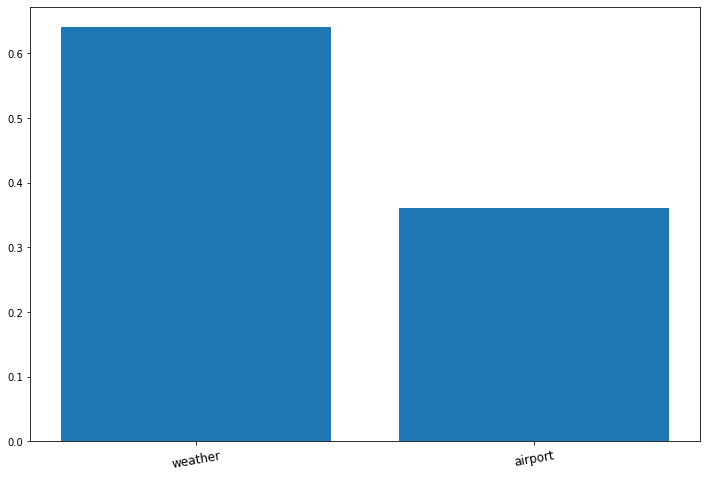

In [43]:
# TODO：导入一个有'feature_importances_'的监督学习模型
from sklearn.ensemble import AdaBoostClassifier

# TODO：在训练集上训练一个监督学习模型，初始化
ada_model = AdaBoostClassifier()

# TODO: fit 训练集
ada_model.fit(X_train, y_train)

# 提取特征重要性 
import matplotlib.pyplot as plt
features = ["weather", "airport"]

feature_important = ada_model.feature_importances_
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(features)),feature_important)
plt.xticks(np.arange(len(features)),features,fontsize=12,rotation=10)
plt.show()


#### 问题6：哪一个特征更加重要？这符合你的直觉吗？谈谈你在平时的项目中在做特征工程时，对于使用符合直觉的特征的看法，可以举例说明。

回答问题：weather 特征更为重要，符合直觉：天气直接影响航班是否能起飞。

## 模型对比

目前为止，我们已经对一个实际问题的复杂的数据进行了处理，并抽取了一两个特征，然后进行了模型训练。你可以按照这个流程做更多的特征工程的工作。由于数据量大，我们已经做好了特征工程，同时我们也sample了部分数据，方便接下来对不同模型进行比较。

这一小节，我们要学习在具体业务场景经常使用的模型，梯度提升决策树 （Gradient Boosting Decison Tree，GBDT）。GBDT在工业场景和各大数据挖掘比赛中都是非常流行的模型，在这里，我们尝试对这些流行对模型进行初探。

#### 问题7：通俗的解释什么是梯度提升决策树 （Gradient Boosting Decison Tree，GBDT）？并列举其优缺点。

回答问题：GBDT 是一种集成算法，其关键是利用损失函数的负梯度方向在当前模型的值作为残差的近似值，进而拟合一颗CART回归树，并把多棵决策树的结果累积作为最终的预测输出。
* 优点：
    * 在随机森林算法的基础上，性能有所提升，能够灵活地处理各种类型的数据；
    * 防止过拟合。GBDT的最大好处在于，每一步的残差计算其实变相地增大了分错实例(instance)的权重，而已经分对的实例(instance)则都趋向于0。这样后面的树就能越来越专注那些前面被分错的实例(instance)。
    * 它的非线性变换比较多，表达能力强，而且不需要做复杂的特征工程和特征变换。
    * 可解释性强，可以自动做特征重要性排序。
* 缺点：
    * Boost是一个串行过程，只能串行
    * 计算复杂度高，同时不太适合高维稀疏特征
    * 若feature个数太多，每一棵回归树都要耗费大量时间，

参考资料：
* [GBDT、XGBoost、LightGBM的区别和联系](https://marian5211.github.io/2018/03/12/%E3%80%90%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E3%80%91gbdt-xgboost-lightGBM%E6%AF%94%E8%BE%83/)
* [机器学习-GB、GBDT、XGBoost、AdaBoost](https://blog.csdn.net/qq_34229228/article/details/103176757)
* [GBDT原理、优缺点、sklearn实现简介](https://puluwen.github.io/2019/01/GBDT-introduction/)

#### 问题8：目前比较流行的 `GBDT`的变种有 [Xgboost](https://xgboost.readthedocs.io/en/latest/) 和 [LightGBM](https://lightgbm.readthedocs.io/en/latest/)，请比较这三个梯度提升模型，列举他们各自的特点? （你可以参考一些文档，并给出你的引用出处）

回答问题：
1. GBDT：机器学习算法，新模型使得原有模型残差往梯度下降的方法；
2. Xgboost：基于 GBDT 算法的工程实现，
    * 代价函数的处理方式：
        * 从 GBDT 原有只使用一阶导数信息到对代价函数进行二阶泰勒展开；
        * XGBoost 在代价函数还加入了正则项，用于控制模型的复杂度
    * 分类器：从 GBDT 原有的以 CART 回归树作为基学习器，到同时支持线性分类器
    * 加速：在每棵树的每个结点需要选择最优特征时，使用多线程并行地计算各个特征的损失，从而减少了运算时间
    * 支持列抽样：分裂树结点时只考虑部分特征
    * 加入了缩减：每次更新fm之前，把叶子结点的输出乘以一个系数η
    
3. LightGBM：基于 GBDT 算法的工程实现，在传统的GBDT基础上引入了两个新技术和一个改进
    * 减少数据量：使用 GOSS 技术去掉了大部分梯度很小的数据，避免低梯度长尾部分的影响；
    * 减少特征量：使用 EFB 技术使捆绑互斥的特征减少了特征量；
    * 加速：从 GBDT 原有的 pre-sorted 方法替换到了 histogram 方法，可以更快找到划分点。

参考资料：
* [GBDT、XGBoost、LightGBM的区别和联系](https://marian5211.github.io/2018/03/12/%E3%80%90%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E3%80%91gbdt-xgboost-lightGBM%E6%AF%94%E8%BE%83/)
* [机器学习-GB、GBDT、XGBoost、AdaBoost](https://blog.csdn.net/qq_34229228/article/details/103176757)
* [随机森林 | GBDT | XGBOOST | LightGBM 比较](https://blog.csdn.net/zhang15953709913/article/details/84587425)

我们已经预先对该数据做了充分的特征工程，然后 `sample` 出了部分数据。数据在路径 `./data_sample/`下面，有训练集`train.csv`和测试集`test.csv`

In [2]:
# 直接运行读取数据，并分别得到 X 和 Y 的数据
import pandas as pd
# 处理训练集
train_x = pd.read_csv("./data_sample/train.csv")
train_y = train_x["飞机延误目标"].values
del(train_x["飞机延误目标"])
# 处理测试集
test_x = pd.read_csv("./data_sample/test.csv")
test_y = test_x["飞机延误目标"].values
del(test_x["飞机延误目标"])

### 对 gbdt 进行调参

按照上面简单模型构建部分的流程，先定义一个梯度提升决策树分类器 GradientBoostingClassifier，并设置里面固定参数；然后设置需要调优的参数，然后通过 网格搜索 `GridSearchCV` 进行搜索最优参数。由于数据量已经减少，这里你可以将参数设置的大一些，以提升模型的准确度，但要防止过拟合。

In [3]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 19 columns):
Unnamed: 0    20000 non-null int64
出发机场          20000 non-null int64
到达机场          20000 non-null int64
航班编号          20000 non-null int64
飞机编号          20000 non-null float64
计划飞行时间        20000 non-null float64
计划起飞时刻        20000 non-null int64
航班月份          20000 non-null int64
计划到达时刻        20000 non-null int64
前序延误          20000 non-null float64
起飞间隔          20000 non-null float64
到达特情          20000 non-null int64
出发特情          20000 non-null int64
出发天气          20000 non-null int64
出发气温          20000 non-null int64
到达天气          20000 non-null int64
到达气温          20000 non-null int64
航空公司          20000 non-null int64
航班性质          20000 non-null int64
dtypes: float64(4), int64(15)
memory usage: 2.9 MB


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import fbeta_score, accuracy_score
import random


#TODO：设置 GBDT 分类器，设置需要调的参数
gbdt_param = {'learning_rate': [0.06, 0.08, 0.10]}
              
gbdt_search = GridSearchCV(estimator = GradientBoostingClassifier(loss="exponential", 
                                                                  max_depth=6, 
                                                                  n_estimators=100, 
                                                                  min_samples_leaf=50),
                       param_grid = gbdt_param,cv=4, scoring="roc_auc")
#模型训练
gbdt_search.fit(train_x,train_y)

# TODO：打印最优参数
print(gbdt_search.best_estimator_)

#使用最优参数预测，并计算精度和准确度
gbdt_clf = gbdt_search.best_estimator_

gbdt_best_predictions = gbdt_clf.predict(test_x)

fpr, tpr, thresholds = metrics.roc_curve(test_y, gbdt_best_predictions)
auc=metrics.auc(fpr, tpr)

print("准确率：{}".format(auc))

#原来的计算准确率方法
#gbdt_best_acc = accuracy_score(test_y, gbdt_best_predictions)
#print('gbdt_best_acc',gbdt_best_acc)

gbdt_f_best_score = fbeta_score(test_y, gbdt_best_predictions,beta=0.5,
                      average='weighted',labels=np.unique(gbdt_best_predictions))

print('gbdt_best_f_score',gbdt_f_best_score)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=50, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
准确率：0.5041666666666667
gbdt_best_f_score 0.2989716992445137


### 对 Xgboost 进行调参
关于xgboost 的参数设置和调参与gbdt类似，参数也是类似的，比如 `n_estimators`表示树的个数；`max_depth`表示构建树的深度，越大越容易过拟合；`gamma`表示用于控制是否后剪枝的参数；`reg_lambda`是用来控制模型复杂度的L2正则化的参数，值越大，模型越不容易过拟合，等等。由于数据量已经减少，这里你可以将参数设置的大一些，以提升模型的准确度，但要防止过拟合。

如果没有安装过xgboost，你需要先运行以下代码来安装 xgboost

In [ ]:
!pip install xgboost

In [9]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import fbeta_score, accuracy_score
import random

#设置参数
xgb_param = {
 'max_depth':range(3,14,2)
# 'gamma':list([0.1, 0.3, 0.6]),
# 'min_samples_split':range(100,200,20),
# 'reg_lambda':list([0.05, 0.1, 1])
}

#设置 xgboost 分类器和网格搜索
xgb_search = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1), 
                          param_grid = xgb_param, 
                          scoring='roc_auc',
                          cv=5)

#模型训练
xgb_search.fit(train_x, train_y)

#打印最优参数
print(xgb_search.best_estimator_)

#使用最优参数预测，并计算精度和准确度
xgbt_clf = xgb_search.best_estimator_

xgbt_best_predictions = xgbt_clf.predict(test_x)

xgb_f_best_score = fbeta_score(test_y, xgbt_best_predictions,beta=0.5,
                      average='weighted',labels=np.unique(xgbt_best_predictions))

xgb_best_acc = accuracy_score(test_y, xgbt_best_predictions)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [10]:
print('xgb_f_best_score',xgb_f_best_score)
print('xgb_best_acc',xgb_best_acc)

xgb_f_best_score 0.29814880125026794
xgb_best_acc 0.504


#### 问题9：在这个任务中，`GBDT`和`xgboost`的性能如何？哪一个更优？通过此次对比和调参过程，总结你对**梯度提升决策树**调参的经验与总结

回答问题：
1. GBDT 和 xgboost 性能对比：就 f_score 和准确度而言，二者相差不大；就运行速度而言，GBDT 更快。
2. 调参的经验与总结：需要根据数据集选择合适的参数，及相应的参数范围。